In [3]:
# !pip install -q datasets nltk scikit-learn matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.grid'] = True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Loads the counseling dataset from HuggingFace
data = load_dataset("Amod/mental_health_counseling_conversations")

df = pd.DataFrame(data["train"])

print("Columns:", df.columns.tolist())
df.head()

README.md: 0.00B [00:00, ?B/s]

combined_dataset.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/3512 [00:00<?, ? examples/s]

Columns: ['Context', 'Response']


,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [5]:
# Combines Context + Response and cleans the text
stop_words = set(stopwords.words('english'))

def clean_text(s: str) -> str:
    """Lowercase, remove punctuation, collapse spaces, remove stopwords."""
    s = s.lower()
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    tokens = [w for w in s.split() if w not in stop_words]
    return ' '.join(tokens)

context = df.get('Context', pd.Series([''] * len(df))).fillna('').astype(str)
response = df.get('Response', pd.Series([''] * len(df))).fillna('').astype(str)

df['text'] = (context + " " + response).str.strip()

df = df[df['text'].str.len() > 5].copy()

df['clean'] = df['text'].apply(clean_text)

print("Rows after filtering:", len(df))
df[['text', 'clean']].head(5)

Rows after filtering: 3512


,text,clean
0,I'm going through some things with my feelings...,going things feelings barely sleep nothing thi...
1,I'm going through some things with my feelings...,going things feelings barely sleep nothing thi...
2,I'm going through some things with my feelings...,going things feelings barely sleep nothing thi...
3,I'm going through some things with my feelings...,going things feelings barely sleep nothing thi...
4,I'm going through some things with my feelings...,going things feelings barely sleep nothing thi...


In [6]:
# Converts cleaned text into TF-IDF numerical features
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3
)

X = vectorizer.fit_transform(df['clean'])
print("TF-IDF shape:", X.shape)

TF-IDF shape: (3512, 5000)


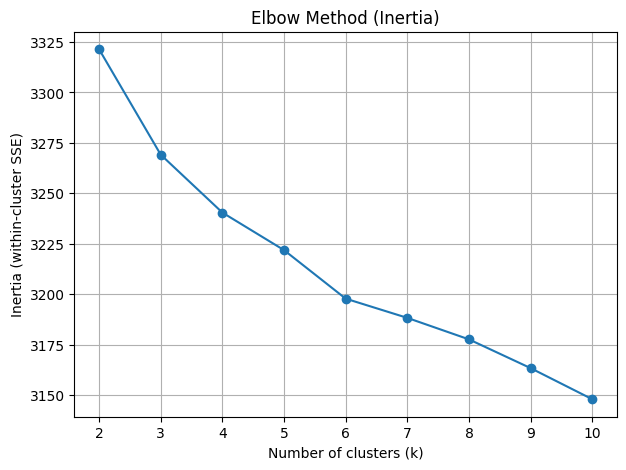

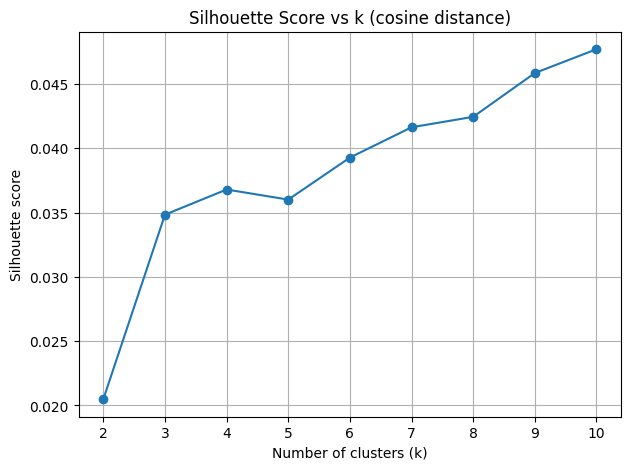

,k,inertia,silhouette
0,2,3321.411347,0.020483
1,3,3269.139314,0.034836
2,4,3240.434394,0.036792
3,5,3221.823425,0.036007
4,6,3197.760841,0.039276
5,7,3188.228448,0.041632
6,8,3177.576414,0.042445
7,9,3163.320269,0.045852
8,10,3147.902968,0.047703


In [7]:
# Test k = 2..10 and plot Elbow + Silhouette scores
k_values = list(range(2, 11))
inertias = []
silhouettes = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil = silhouette_score(X, labels, metric='cosine')
    silhouettes.append(sil)

# Elbow
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.show()

# Silhouette
plt.plot(k_values, silhouettes, marker='o')
plt.title("Silhouette Score vs k (cosine distance)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.show()

pd.DataFrame({"k": k_values, "inertia": inertias, "silhouette": silhouettes})

In [8]:
K_FINAL = 7

kmeans = KMeans(n_clusters=K_FINAL, random_state=RANDOM_STATE, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(X)

df['cluster_kmeans'].value_counts().sort_index()

cluster_kmeans
0     115
1     592
2    1140
3      81
4      74
5    1416
6      94
Name: count, dtype: int64

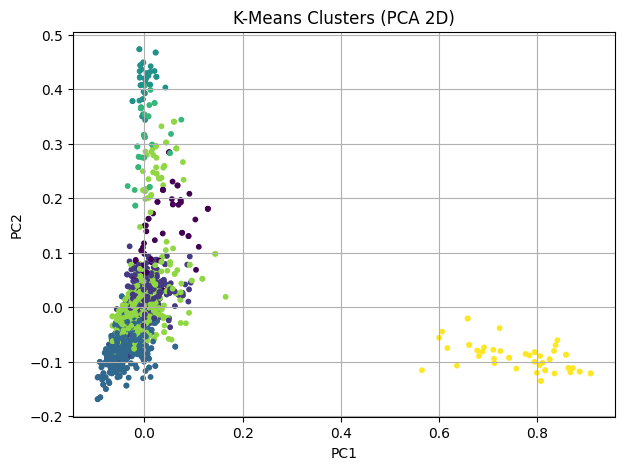

In [9]:
MAX_POINTS = 2000
if X.shape[0] > MAX_POINTS:
    idx = np.random.choice(X.shape[0], size=MAX_POINTS, replace=False)
    X_sample = X[idx].toarray()
    y_sample = df['cluster_kmeans'].iloc[idx].values
else:
    X_sample = X.toarray()
    y_sample = df['cluster_kmeans'].values

pca = PCA(n_components=2, random_state=RANDOM_STATE)
coords = pca.fit_transform(X_sample)

plt.scatter(coords[:, 0], coords[:, 1], c=y_sample, s=10)
plt.title("K-Means Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [10]:
# Examines the top TF-IDF terms per cluster
terms = np.array(vectorizer.get_feature_names_out())
centers = kmeans.cluster_centers_

TOPN = 15
for c in range(K_FINAL):
    top_idx = np.argsort(centers[c])[::-1][:TOPN]
    top_terms = terms[top_idx]
    print(f"\nCluster {c} — Top terms:")
    print(", ".join(top_terms))


Cluster 0 — Top terms:
client, therapist, counselor, sessions, counseling, end, right therapist, therapy, terminate, counseling sessions, end counseling, treatment, train, train therapist, terminate working

Cluster 1 — Top terms:
anxiety, thoughts, depression, help, stress, get, may, feel, like, would, people, symptoms, doctor, things, therapist

Cluster 2 — Top terms:
relationship, love, boyfriend, want, like, time, partner, sex, husband, feel, would, know, may, trust, one

Cluster 3 — Top terms:
que, de, la, en, el, tu, es, para, con, te, una, si, un, las, los

Cluster 4 — Top terms:
nervous, therapy, still, shaky, sessions, nervous shaky, therapy sessions, still feeling, get nervous, walk get, sessions far, shaky normal, still everytime, gone couple, everytime walk

Cluster 5 — Top terms:
feel, people, like, may, life, help, time, know, someone, would, child, feeling, way, one, get

Cluster 6 — Top terms:
many issues, issues, issues address, address, counseling, history, many, add

In [11]:
# Shows sample messages from each cluster
SAMPLES_PER_CLUSTER = 5

for c in range(K_FINAL):
    print(f"\nCluster {c} examples")
    cluster_df = df[df['cluster_kmeans'] == c]
    n = min(SAMPLES_PER_CLUSTER, len(cluster_df))
    examples = cluster_df.sample(n, random_state=RANDOM_STATE)['text'].tolist()

    for t in examples:
        print("-", t[:300].replace("\n", " "), "...")


Cluster 0 examples
- How does a counselor decide when to end counseling sessions or to terminate working with a client? Hi there, There are a number of reasons why a therapeutic relationship might end including, but not limited to the client reaching their goals, the client reaching a place of acceptance where they wish ...
- How does a counselor decide when to end counseling sessions or to terminate working with a client? From the very beginning of counseling sessions I emphasize that the work will and must end at some point.In counseling there is an arc to the process. A beginning, middle and end. I am always digging,  ...
- How do you know you have the right therapist for you?  How would I know how to "train" my therapist to be able to give me what I need from treatment? How do you know anything is "right" for you? I think it's an intuitive process, and not always based on the objective expertise of the therapist, eith ...
- How does a counselor decide when to end counseling sessio

Agglomerative cluster sizes: {0: 428, 1: 9, 2: 10, 3: 16, 4: 12, 5: 15, 6: 10}


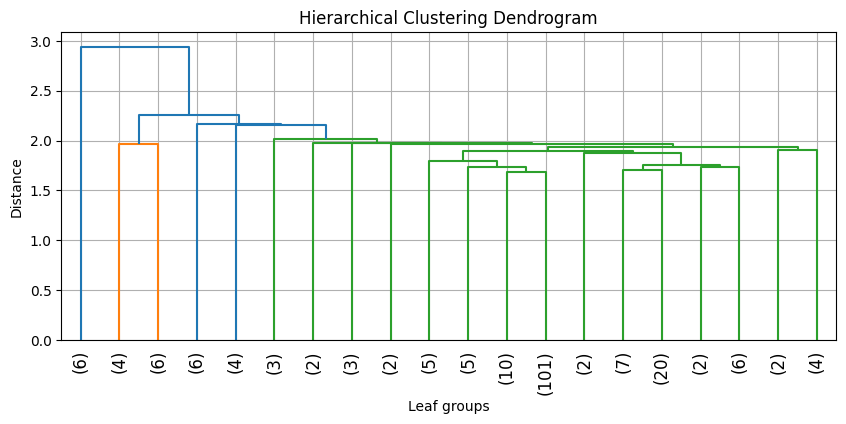

In [12]:
# Hierarchical clustering + dendrogram
H_SAMPLES = 500
if X.shape[0] > H_SAMPLES:
    idx_h = np.random.choice(X.shape[0], size=H_SAMPLES, replace=False)
    X_h = X[idx_h].toarray()
else:
    X_h = X.toarray()

agg = AgglomerativeClustering(n_clusters=K_FINAL, linkage='ward')
h_labels = agg.fit_predict(X_h)

print("Agglomerative cluster sizes:", pd.Series(h_labels).value_counts().sort_index().to_dict())

# Dendrogram on a smaller subset
D_SAMPLES = min(200, X_h.shape[0])
Z = linkage(X_h[:D_SAMPLES], method='ward')

plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode='lastp', p=20, leaf_rotation=90.)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Leaf groups")
plt.ylabel("Distance")
plt.show()

In [13]:
# Compares K-Means vs Agglomerative clustering
km_h = KMeans(n_clusters=K_FINAL, random_state=RANDOM_STATE, n_init=10)
km_h_labels = km_h.fit_predict(X_h)

try:
    sil_km = silhouette_score(X_h, km_h_labels, metric='cosine')
    sil_ag = silhouette_score(X_h, h_labels, metric='cosine')
    print(f"Silhouette (cosine) — K-Means: {sil_km:.3f}  |  Agglomerative: {sil_ag:.3f}")
except Exception as e:
    print("Silhouette comparison skipped:", e)

Silhouette (cosine) — K-Means: 0.045  |  Agglomerative: 0.056


In [14]:
df[['text', 'clean', 'cluster_kmeans']].to_csv("mhcc_clusters_k7.csv", index=False)

records = df[['text', 'cluster_kmeans']].to_dict(orient='records')
with open("mhcc_clusters_k7.json", "w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)

print("Saved mhcc_clusters_k7.csv and mhcc_clusters_k7.json")

Saved mhcc_clusters_k7.csv and mhcc_clusters_k7.json
